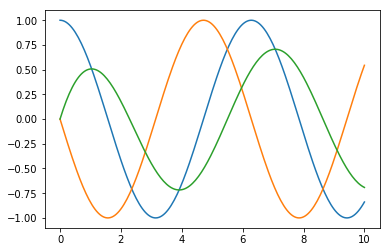

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def matrix_exponential(A):
    L, P = np.linalg.eig(A)
    D    = np.diag(np.exp(L))
    B    = P.dot(D).dot(np.linalg.inv(P))  
    return B

def ode_solution(A, h, t0, tf, x0):
    xs = [x0]
    x  = x0.copy()
    ts = [t0]
    t  = t0
    M  = np.real_if_close(matrix_exponential(A*h))
    
    while t < tf:
        x = M@x
        h = min(h, tf - t)
        t = t + h
        
        xs.append(x.copy())
        ts.append(t)
        
    return np.array(ts), np.array(xs)

k  = 1
A  = np.array([[0, 1, 0],[-1, 0, 0],[k, 0, -k]])
x0 = np.array([1, 0, 0])
t0 = 0
tf = 10
h  = .05

ts, xs = ode_solution(A, h, 0, tf, x0)
plt.plot(ts, xs);

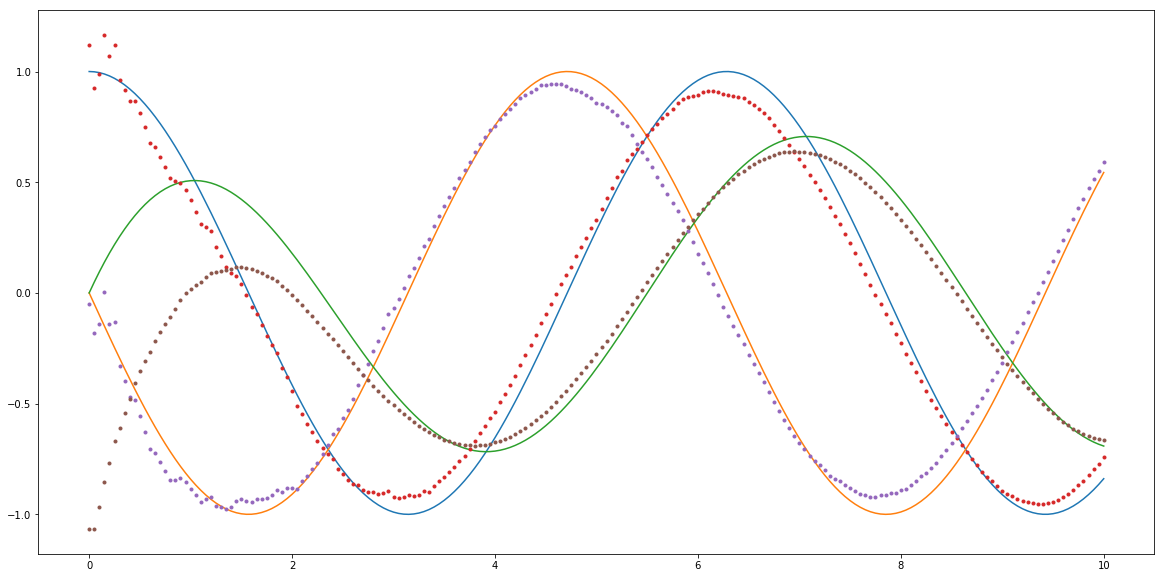

In [2]:
def KalmanFilterLinOde(A, H, t0, tf, h, xt0, xf0, Pf, Q, R, x_dims, sigma_obs):
    
    # function paramaters:
    
    # A      : ODE matrix
    # H      : observation operator
    # t0     : initial time
    # tf     : final time
    # h      : timestep
    # xt0    : true value of initial state vector
    # xf0    : guess of initial state variable (background)
    # Pf     : forecast/initial state error covariance matrix 
    # Q      : model noise matrix (unbiased, uncorrelated noise)
    # R      : observation noise matrix (unbiased, uncorrelated noise)
    # x_dims : number of dimensions of state variable
    # noise  : the scale of the noise added to true state vectors

    
    # other things used in Kalman Filter:
    
    # M      : solution to matrix A at time t
    # K      : optimal Kalman gain matrix 
    # xf     : forecast state variable at arbitrary time
    # xa     : analysis state variable at arbitrary time
    
    ts = [t0]
    xs = [xf0]
    t  = t0
    xf = xf0
    M  = np.real_if_close(matrix_exponential(A*h))
    xt = xt0.copy()
    
    while t < tf:
        K  = Pf@H.T@np.linalg.inv(H@Pf@H.T + R)  # computing Kalman gain 
        xt = M@xt
        y  = H@xt + np.random.normal()*sigma_obs # generating observation with white noise
            
        xa = xf + K@(y - H.dot(xf))              # computing analysis vector
        Pa = (np.eye(x_dims) - K@H)@Pf           # computing analysis error covariance
        xf = M@xa
        Pf = M@Pa@M.T + Q                        # computing forecast covariance
        
        t  = t + h
        ts.append(t)
        xs.append(xa.copy())
            
    return np.array(ts), np.array(xs)

    
H  = np.array([[1, 0, 0], [0, 1, 0]])
xt0 = np.array([1, 0, 0])

sigma_initial = .5
x_dims = 3
xf0 = np.random.normal(xt0, scale=sigma_initial)

sigma_obs = .5
sigma_model = .001
Pf = np.eye(3) * sigma_initial**2
Q  = np.eye(3) * sigma_model**2
R  = np.eye(2) * sigma_obs**2

ts, xs_KF = KalmanFilterLinOde(A, H, t0, tf, h, xt0, xf0, Pf, Q, R, x_dims, sigma_obs)

plt.figure(figsize=(20,10))
plt.plot(ts, xs, ts, xs_KF, '.');

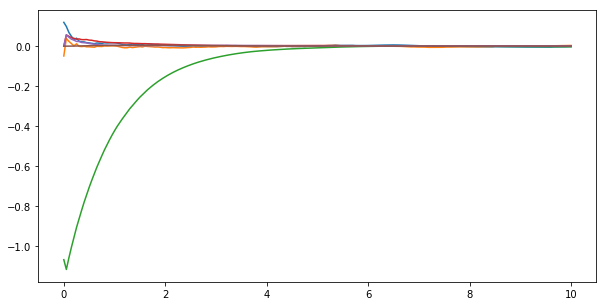

In [3]:
def kf_trials(A, num_trials):
    ts, xs = ode_solution(A, h, t0, tf, x0)
    trials = []
    
    for _ in range(num_trials):
        ts, xs_KF = KalmanFilterLinOde(A, H, t0, tf, h, xt0, xf0, Pf, Q, R, x_dims, sigma_obs)
        trials.append(xs_KF)
        
    return xs, np.array(trials)

k = 1
A = np.array([[0, 1, 0],[-1, 0, 0],[k, 0, -k]])
xs, trials = kf_trials(A, 100)

plt.figure(figsize=(10,5))
plt.plot(ts, np.mean(trials, axis=0) - xs)
plt.plot(ts, np.var(trials, axis=0))

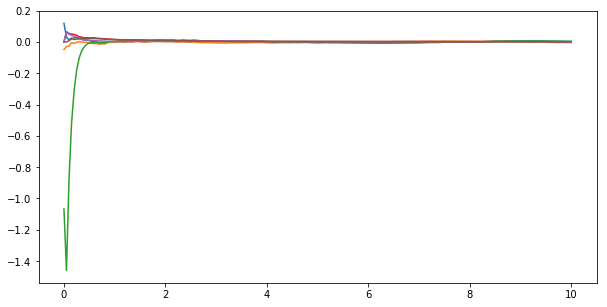

In [5]:
k = 10
A = np.array([[0, 1, 0],[-1, 0, 0],[k, 0, -k]])

xs, trials = kf_trials(A, 100)
plt.figure(figsize=(10,5))
plt.plot(ts, np.mean(trials, axis=0) - xs)
plt.plot(ts, np.var(trials, axis=0));